# Import

In [54]:
import random 
import pandas as pd
import numpy as np
import os
import math

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import tensorflow_addons.metrics
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

from tqdm.auto import tqdm


import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

import seaborn as sns


from numpy import dot
from numpy.linalg import norm

# Hyperparameter Setting

In [55]:
EPOCHS = 400
LR = 1e-2
BATCH_SIZE=10000
SEED = 42
LABELS = ["Normal", "Fraud"]

# Fixed Seed

In [56]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

# Load Data

In [57]:
train_df = pd.read_csv('./train.csv')
train_df = train_df.drop(columns=['ID'])

val_df = pd.read_csv('./val.csv')
val_df = val_df.drop(columns=['ID'])

# AutoEncdoer

In [58]:

class AutoEncoder(tf.keras.Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(128),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU()
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(30)
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

# Train

## GPU

In [59]:
print('GPU 여부: ', len(tf.config.list_logical_devices('GPU'))>0)

if tf.config.list_logical_devices('GPU'):
    device_name = tf.test.gpu_device_name()
else:
    device_name='/CPU:0'
print(device_name)

GPU 여부:  True
/device:GPU:0


In [61]:
train_df = pd.read_csv('./train.csv')
train_df = train_df.drop(columns=['ID'])

val_df = pd.read_csv('./val.csv')
val_df = val_df.drop(columns=['ID'])

In [62]:
X_train = train_df.values

X_val = val_df.drop(columns=['Class']).values
y_val = val_df['Class'].values

In [63]:
model = AutoEncoder()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss = tf.keras.losses.MeanAbsoluteError(),
    metrics=['accuracy']
)

callback_list = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',mode='auto', factor=0.5, patience=5, min_lr=1e-8, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath='./save_model/model.tf', save_best_only=True)
]

# 멀티 GPU 사용
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    history = model.fit(
        X_train, X_train,
        epochs=EPOCHS,
        callbacks=callback_list,
        batch_size=BATCH_SIZE,
        shuffle=True,
        validation_data=(X_val, X_val),
        verbose=1).history

Epoch 1/400
12/12 [==============================] - 1s 61ms/step - loss: 0.4676 - accuracy: 0.4801 - val_loss: 0.3938 - val_accuracy: 0.5878
Epoch 2/400
12/12 [==============================] - 1s 50ms/step - loss: 0.2337 - accuracy: 0.7685 - val_loss: 0.4422 - val_accuracy: 0.7196
Epoch 3/400
12/12 [==============================] - 1s 46ms/step - loss: 0.1747 - accuracy: 0.8419 - val_loss: 0.4439 - val_accuracy: 0.7882
Epoch 4/400
12/12 [==============================] - 1s 43ms/step - loss: 0.1432 - accuracy: 0.8692 - val_loss: 0.4435 - val_accuracy: 0.7985
Epoch 5/400
12/12 [==============================] - 1s 47ms/step - loss: 0.1266 - accuracy: 0.8791 - val_loss: 0.4494 - val_accuracy: 0.8071
Epoch 6/400
12/12 [==============================] - 1s 44ms/step - loss: 0.1154 - accuracy: 0.8911 - val_loss: 0.4224 - val_accuracy: 0.8086

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 7/400
12/12 [==============================] - 0s 41ms/step - 

# Evaluate

In [64]:
autoencoder = tf.keras.models.load_model('./save_model/model.tf')

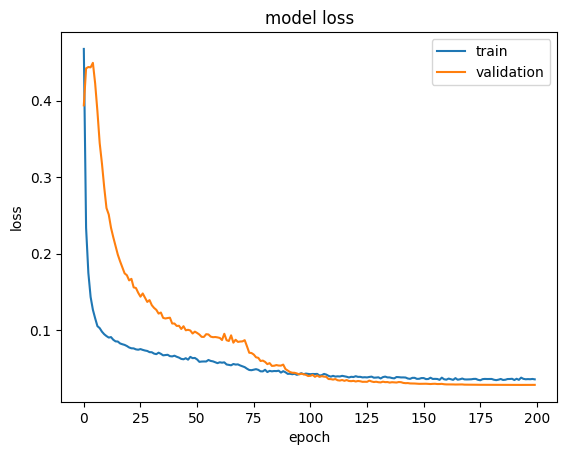

In [73]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

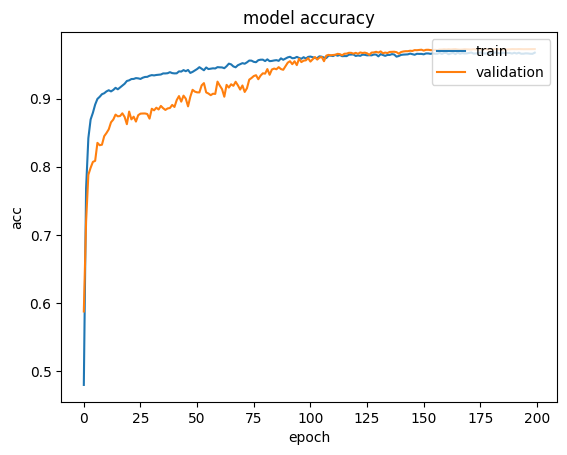

In [74]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

In [75]:
predictions = autoencoder.predict(X_val)
mse = np.mean(np.power(X_val - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_val})
error_df.describe()

,reconstruction_error,true_class
count,28462.000000,28462.000000
mean,0.017726,0.001054
std,0.620148,0.032449
min,0.000032,0.000000
25%,0.000334,0.000000
50%,0.000698,0.000000
75%,0.001542,0.000000
max,32.396124,1.000000


In [82]:
error_df

,reconstruction_error,true_class
0,0.000297,0
1,0.000522,0
2,0.000497,0
3,0.000287,0
4,0.004565,0
...,...,...
28457,0.000280,0
28458,0.000743,0
28459,0.000895,0
28460,0.000172,0


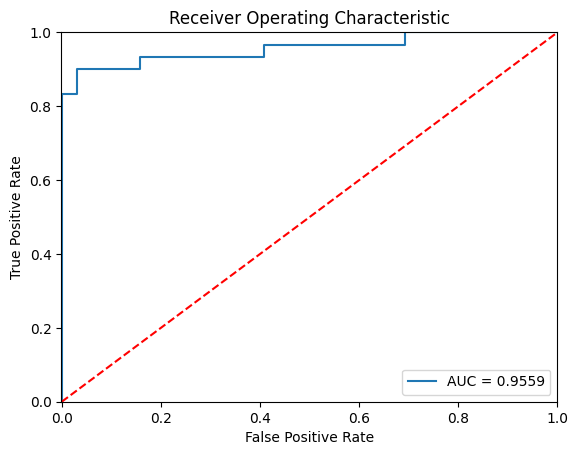

In [76]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


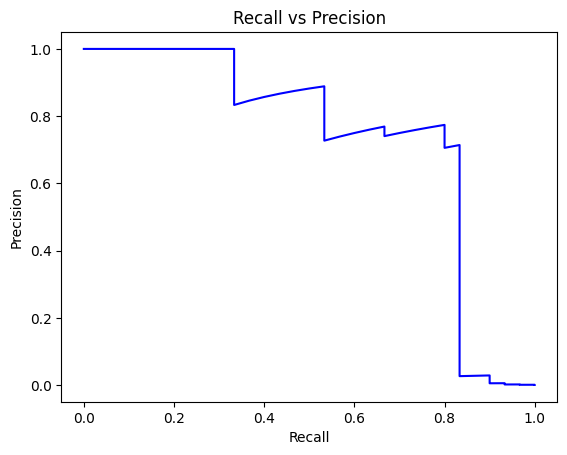

In [77]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

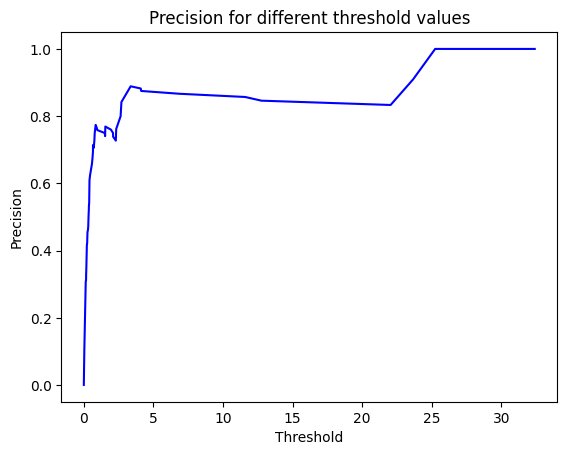

In [78]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

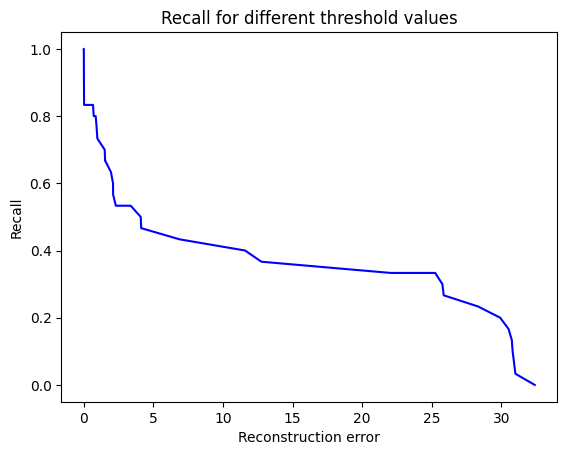

In [79]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

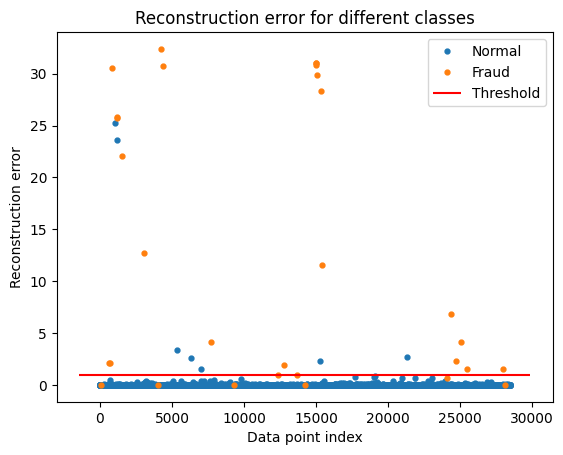

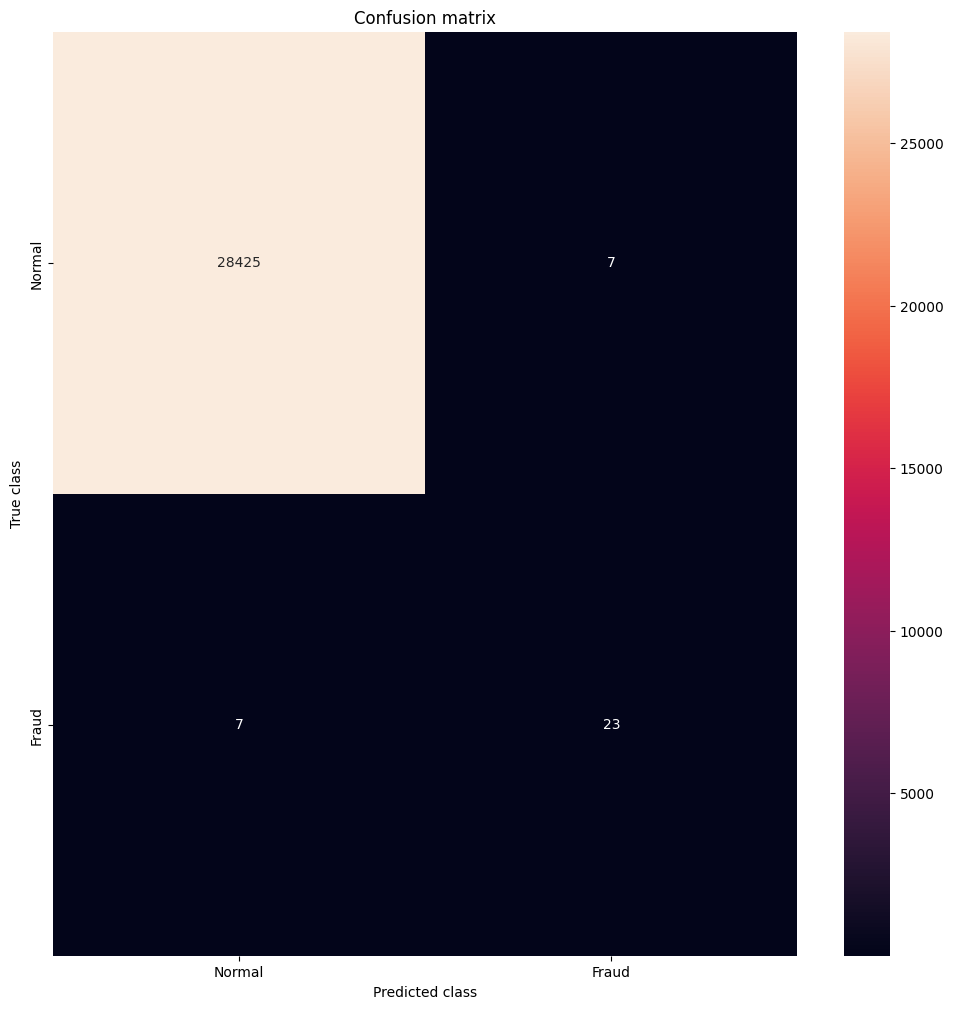

Validation F1 Score :  [0.8832102326017632]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.77      0.77      0.77        30

    accuracy                           1.00     28462
   macro avg       0.88      0.88      0.88     28462
weighted avg       1.00      1.00      1.00     28462



In [81]:
threshold = 0.95

groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

val_score = f1_score(y_val, y_pred, average='macro')
print(f'Validation F1 Score :  [{val_score}]')
print(classification_report(y_val, y_pred))


# Inference

In [49]:
test_df = pd.read_csv('./test.csv')
test_df = test_df.drop(columns=['ID'])

In [50]:
X_test = test_df.values

In [51]:
pred = autoencoder.predict(X_test)

In [52]:
def cos_sim(A,B):
    return dot(A,B)/(norm(A)*norm(B))


pred_list = []
cnt = 0
while cnt!=len(pred):
    cos = cos_sim(X_test[cnt], pred[cnt])
    if cos<threshold:
        pred_list.append(1)
    else:
        pred_list.append(0)
    cnt += 1


# Submission

In [53]:
submit = pd.read_csv('./sample_submission.csv')
submit['Class'] = pred_list
submit.to_csv('./autoencoder.csv', index=False)